## Import Libraries 

In [1]:
import numpy as np
from PIL import Image, ImageOps # to read and manipulate photos
import matplotlib.pyplot as plt
import math

## Define DoG and Gabor filters

### Gaussian kernel

### Gaussian Distribution in 2D
$$
G_{\sigma}(x,y) = e^{-(x^2 + y^2)/2\sigma^2}/\sigma\sqrt{2.\pi}
$$

In [2]:
def get_gaussian_kernel(kernel_size=3, sigma=2):
    ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)

### DoG kernel

$$
DoG_{\sigma_1 , \sigma_2} = G_{\sigma_1}(x,y) - G_{\sigma_2}(x,y) 
$$

In [3]:
def get_DoG_kernel(kernel_size = 5 , sigma_1 = 2 , sigma_2 = 5):
    return gaussian_kernel(kernel_size , sigma_1) - gaussian_kernel(kernel_size , sigma_2)

### Gabor kernel

$$
g(x,y,\lambda,\theta,\sigma,\gamma) = exp(-(X^2 + \gamma^2.Y^2)/2\sigma^2).cos(2.\pi.X/\lambda)
$$
$$
X = xcos(\theta) + ysin(\theta)
$$
$$
Y = -xsin(\theta) + ycos(\theta)
$$

In [4]:
def gabor_kernel(kernel_size=51, sigma=10, gamma=1.2, lamb=10, angle=45):
    d = kernel_size // 2
    # prepare kernel
    gabor_kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    # each value
    for y in range(kernel_size):
        for x in range(kernel_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor_kernel[y, x] = np.exp(-(_x ** 2 + gamma ** 2 * _y ** 2) / (2 * sigma ** 2)) * np.cos(
                2 * np.pi * _x / lamb)

    # kernel normalization
    gabor_kernel /= np.sum(np.abs(gabor_kernel))

    return gabor_kernel

## Convolution

### With padding

In [5]:
def add_padding(image , rows , cols):
    row_len , col_len = image.shape
    row_padding = np.zeros((rows , col_len))
    image = np.concatenate((row_padding , image) , axis=0)
    image = np.concatenate((image,row_padding) , axis=0)
    row_len += 2*(rows)
    col_padding = np.zeros((row_len , cols))
    image = np.concatenate((col_padding , image) , axis=1)
    image = np.concatenate((image,col_padding) , axis=1)
    return image

In [6]:
def get_pixel_matrix(img , row , col , added_row , added_col , kernel_size):
    row_start , row_end = row - added_row , row + added_row
    col_start , col_end = col - added_col , col + added_col
    if kernel_size % 2 == 1:
        return img[row_start:row_end+1 , col_start:col_end+1]
    return img[row_start:row_end , col_start:col_end]


def apply_kernel(image , kernel , strides = 1):
    rows_to_add , cols_to_add = kernel.shape[0] // 2 , kernel.shape[1] // 2
    padded_img = add_padding(image , rows_to_add , cols_to_add)
    output_shape_0 , output_shape_1 = math.floor((padded_img.shape[0] - kernel.shape[0]) / strides) + 1 , math.floor((padded_img.shape[1] - kernel.shape[1]) / strides) + 1
    result_img = np.zeros((output_shape_0 , output_shape_1))
    for row_idx in range(0 , image.shape[0] , strides):
        for col_idx in range(0 , image.shape[1] , strides):
            row_index , col_index = (row_idx + rows_to_add , col_idx + cols_to_add) #address of pixel in padded image
            curr_pixel_matrix = get_pixel_matrix(padded_img , row_index , col_index , rows_to_add , cols_to_add , kernel.shape[0])
            result_img[row_idx//strides , col_idx//strides] = np.sum(np.multiply(curr_pixel_matrix, kernel))
    return result_img

### Without padding (assuming square images)

In [7]:
def calculate_target_size(img_size: int, kernel_size: int , strides:int) -> int:
    num_pixels = 0
    for i in range(0 , img_size , strides):
        added = i + kernel_size
        if added <= img_size:
            num_pixels += 1
    return num_pixels

In [8]:
def convolve(img: np.array, kernel: np.array , strides:int) -> np.array:
    tgt_size = calculate_target_size(img_size=img.shape[0],kernel_size=kernel.shape[0],strides=strides)
    k = kernel.shape[0]
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    for i in range(0 , tgt_size):
        for j in range(0 , tgt_size):
            mat = img[i * strides:i*strides+k, j*strides:j*strides+k]
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img

In [9]:
def negative_to_zero(img: np.array) -> np.array:
    img = img.copy()
    img[img < 0] = 0
    return img

### Read image and pre process

In [10]:
def get_image(size:tuple , path:str) -> np.array:
    img = Image.open(path)
    img = ImageOps.grayscale(img)
    img = img.resize(size=size)
    return np.asarray(img)

## Plotting functions

In [11]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');

In [12]:
def plot_kernel_image(img: np.array, kernel: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(kernel, cmap='gray')
    ax[0].set_title('Kernel')
    ax[1].imshow(img, cmap='gray');
    ax[1].set_title('Result')

## Put them all together

In [16]:
def convolution(img_path:str , img_size:int , kernel_type:str , params:dict , padding:bool , strides:int , plot:bool=True) -> np.array:
    image = get_image((img_size , img_size) , img_path)
    if kernel_type == 'DoG':
        kernel = get_DoG_kernel(**params)
    else:
        kernel = gabor_kernel(**params)
    if padding:
        result = apply_kernel(image ,kernel , strides=strides)
    else:
        result = convolve(image , kernel , strides=strides)
    #result = negative_to_zero(result)
    if plot:
        plot_kernel_image(result , kernel)
    return result

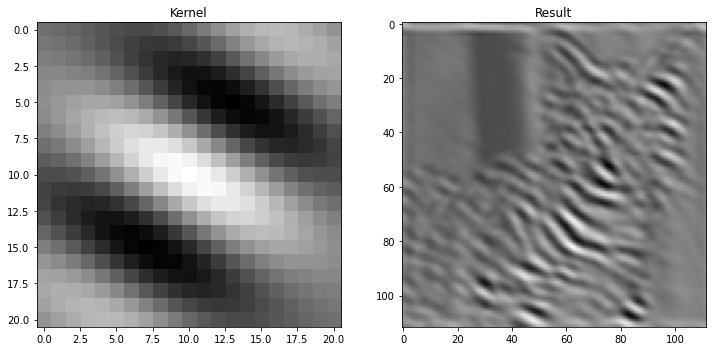

In [17]:
path = 'cat.jpg'
size = 224
k_type = 'Gabor'
params = {
    'kernel_size' : 21 ,
    'sigma': 10.,
    'gamma': 1.6,
    'lamb':12,
    'angle': 120
}
padding =True
strides = 2
covolved_img = convolution(img_path=path , img_size=size , kernel_type=k_type , params=params , padding=padding , strides=strides)

## Max Pooling layer

In [18]:
def max_pool(img , pool_size = 2 , strides = 2):
    input_shape_0 , input_shape_1 = img.shape
    output_shape_0 , output_shape_1 = math.floor((input_shape_0 - pool_size) / strides) + 1 , math.floor((input_shape_1 - pool_size) / strides) + 1
    pools = []
    for row in np.arange(input_shape_0, step=strides):
        for column in np.arange(input_shape_1 , step=strides):
            mat = img[row:row+pool_size, column:column+pool_size]
            
            if mat.shape == (pool_size, pool_size):
                pools.append(np.max(mat))
    return np.array(pools).reshape((output_shape_0 , output_shape_1))


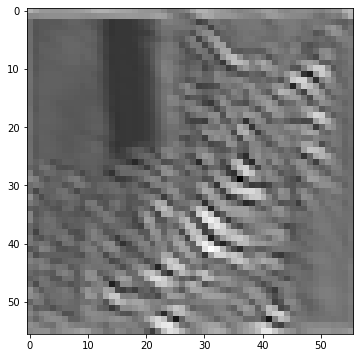

In [19]:
pooled_img = max_pool(covolved_img)
plot_image(pooled_img)